In [1]:
import pandas as pd
from collections import defaultdict, Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import sys


Bad key text.latex.unicode in file /home/dcirillo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/dcirillo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/dcirillo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://gi

In [2]:
# create a unique table with all biomarkers

nanostring_df = pd.read_excel("files/IGTP NANOSTRING.XLSX", sheet_name='Hoja1')
nanostring_df['specimen'] = [re.split('(\d+)',s)[2] for s in nanostring_df['BSC ID']]
nanostring_df['BSC ID'] = [re.split('(\d+)',s)[1] for s in nanostring_df['BSC ID']]
cols = list(nanostring_df)
cols.insert(0, cols.pop(cols.index('specimen')))
nanostring_df = nanostring_df.loc[:, cols]

a = nanostring_df[nanostring_df['specimen']=='SR']
a = a.drop(columns=['specimen']).set_index('BSC ID')
a.columns = [col + "_SR" for col in a.columns]

b = nanostring_df[nanostring_df['specimen']=='BX']
b = b.drop(columns=['specimen']).set_index('BSC ID')
b.columns = [col + "_BX" for col in b.columns]

nanostring_df = pd.concat([a,b])

pathoclin_df = pd.read_excel("files/IGTP GLOBAL TABLE_Anonimized_v3.xlsx", sheet_name='Hoja1')
pathoclin_df['BSC ID'] = pathoclin_df['BSC ID'].astype(str)
pathoclin_df = pathoclin_df.set_index('BSC ID')

df = pd.merge(pathoclin_df, nanostring_df, left_index=True, right_index=True, how='outer')
df = df.reset_index(level=0)
df = df.groupby(['BSC ID','Retrospective1/Prospective2']).max().reset_index().set_index('BSC ID')
df.to_csv('files/IGTP NANOSTRING AND GLOBAL TABLE.tsv',sep='\t')

In [3]:
# Groups of biomarkers
# 1: Nanostring (N=238) 249? 11 están an la tabla de los biomarcadores...
# 2: MRS (N=2)
# 3: QuALU (N=4)
# 4: IHC (N=44)
# 5: CNV (N=12)
# 6: BCAT_ACT (N=1) 2? Usa solo BCAT_ACT...
# 7: Plasma (N=8)
# Clinic: EFS (N=1)
# Pathol: Diagnosis_DEF_3cat (N=1)

annots_df = pd.read_csv('files/Biomarker_annotations.tsv',sep='\t')
annots_df['Time point'] = annots_df['Time point'].str.upper()

lst = []
for index, row in annots_df.iterrows():
    if row['Table'] == 'IGTP Nanostring':
        lst.append(row['Biomarker name']+'_'+row['Time point'])
    else:
        lst.append(row['Biomarker name'])
annots_df['Biomarker name'] = lst
bgroup_dict = {}
for bgroup in annots_df['Biomarker group'].unique():
    bmkrs = list(set(annots_df[annots_df['Biomarker group']==bgroup]['Biomarker name']))
    bgroup_dict[bgroup] = bmkrs

In [4]:
bgroup1_BX = [s for s in bgroup_dict['1'] if '_BX' in s]
bgroup2_BX = [s for s in bgroup_dict['2'] if '_BX' in s]
bgroup3_BX = [s for s in bgroup_dict['3'] if '_BX' in s]
bgroup4_BX = [s for s in bgroup_dict['4'] if '_BX' in s]
bgroup5_BX = [s for s in bgroup_dict['5'] if '_bx' in s] # this is lowercase in the table...
bgroup6_BX = ['BCAT_ACT']
bgroup7_BX = ['DKK1','C1QB','DLK', 'C1QB_10', 'DLK_5', 'DLK_1']

bgroup1_SR = [s for s in bgroup_dict['1'] if '_SR' in s] # with this, we exclude '14q32_Jhep'
bgroup2_SR = [s for s in bgroup_dict['2'] if '_SR' in s]
bgroup3_SR = [s for s in bgroup_dict['3'] if '_SR' in s]
bgroup4_SR = [s for s in bgroup_dict['4'] if '_SR' in s]
bgroup5_SR = [s for s in bgroup_dict['5'] if '_SR' in s]
bgroup6_SR = ['BCAT_ACT']
bgroup7_SR = ['DKK1_EOT','C1QB_EOT '] # this has a space in the colname...

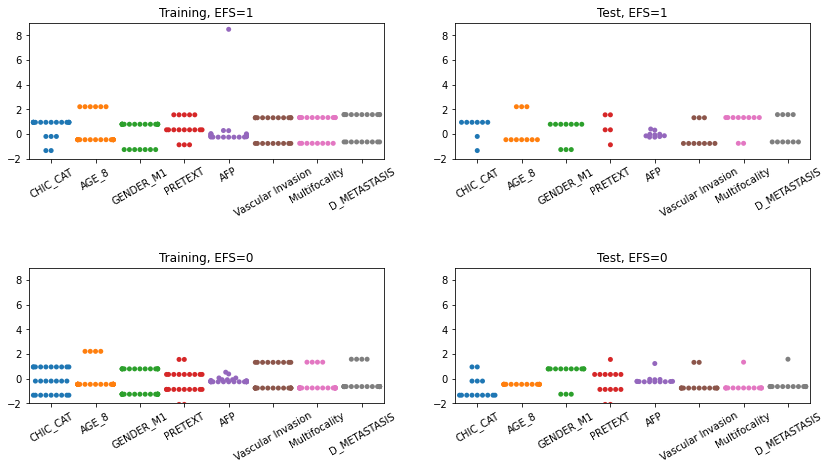

In [5]:
features = ['CHIC_CAT','AGE_8','GENDER_M1','PRETEXT','AFP','Vascular Invasion','Multifocality','D_METASTASIS','EFS','Diagnosis_DEF_3cat']

# prospective cohort stratified split for the EFS study
a = df[(df['Retrospective1/Prospective2']==2) & (df['FU_2yrorEFS1']==1)][features]
y = a['EFS']
a = a.drop(columns=['EFS','Diagnosis_DEF_3cat'])

mapper = DataFrameMapper([(a.columns, StandardScaler())])
scaled_features = mapper.fit_transform(a.copy(), 4)
a = pd.DataFrame(scaled_features, index=a.index, columns=a.columns)
X = a.to_numpy()
idx = a.index
X_train, X_test, y_train, y_test, EFS_idx_train, EFS_idx_test = train_test_split(X, y, idx, test_size = 0.3, random_state = 42, stratify = y)

fig, ax = plt.subplots(2, 2, figsize=(14, 7))
plt.subplots_adjust(hspace = 0.8)
ax = ax.flatten()
sns.swarmplot(data=X_train[np.where(y_train==1)], ax=ax[0]).set_title('Training, EFS=1')
ax[0].set_ylim([-2, 9])
ax[0].set_xticklabels(features[:8],rotation=30)
sns.swarmplot(data=X_test[np.where(y_test==1)], ax=ax[1]).set_title('Test, EFS=1')
ax[1].set_ylim([-2, 9])
ax[1].set_xticklabels(features[:8],rotation=30)
sns.swarmplot(data=X_train[np.where(y_train==0)], ax=ax[2]).set_title('Training, EFS=0')
ax[2].set_ylim([-2, 9])
ax[2].set_xticklabels(features[:8],rotation=30)
sns.swarmplot(data=X_test[np.where(y_test==0)], ax=ax[3]).set_title('Test, EFS=0')
ax[3].set_ylim([-2, 9])
ax[3].set_xticklabels(features[:8],rotation=30)
fig.show()

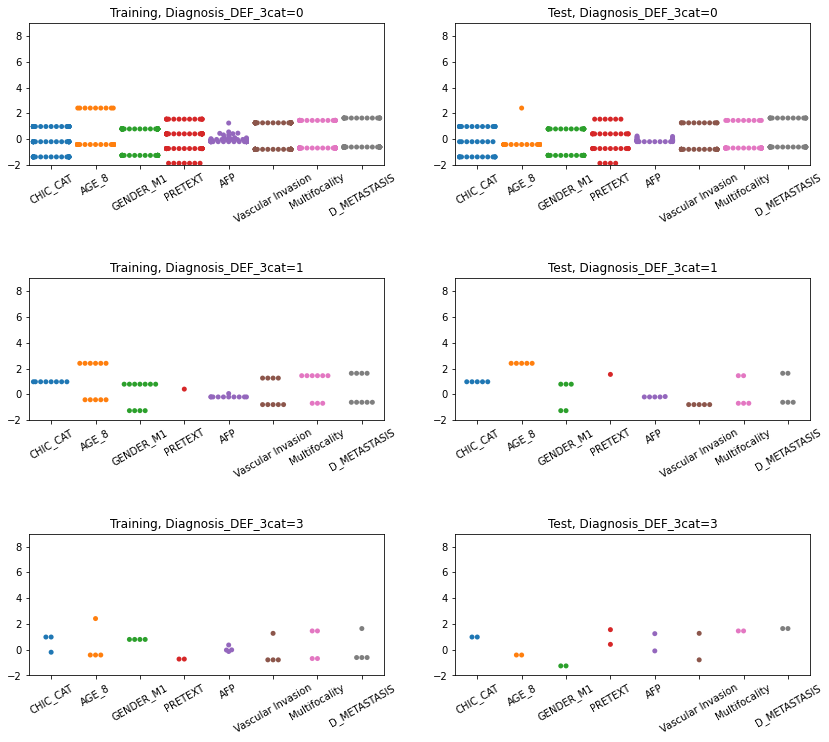

In [6]:
# prospective cohort stratified split for the AP study
a = df[(df['Retrospective1/Prospective2']==2) & (~df['Diagnosis_DEF_3cat'].isna())][features]
y = a['Diagnosis_DEF_3cat']
a = a.drop(columns=['EFS','Diagnosis_DEF_3cat'])

mapper = DataFrameMapper([(a.columns, StandardScaler())])
scaled_features = mapper.fit_transform(a.copy(), 4)
a = pd.DataFrame(scaled_features, index=a.index, columns=a.columns)
X = a.to_numpy()
idx = a.index
X_train, X_test, y_train, y_test, AP_idx_train, AP_idx_test = train_test_split(X, y, idx, test_size = 0.3, random_state = 42, stratify = y)

fig, ax = plt.subplots(3, 2, figsize=(14, 12))
plt.subplots_adjust(hspace = 0.8)
ax = ax.flatten()
sns.swarmplot(data=X_train[np.where(y_train==0)], ax=ax[0]).set_title('Training, Diagnosis_DEF_3cat=0')
ax[0].set_ylim([-2, 9])
ax[0].set_xticklabels(features[:8],rotation=30)
sns.swarmplot(data=X_test[np.where(y_test==0)], ax=ax[1]).set_title('Test, Diagnosis_DEF_3cat=0')
ax[1].set_ylim([-2, 9])
ax[1].set_xticklabels(features[:8],rotation=30)
sns.swarmplot(data=X_train[np.where(y_train==1)], ax=ax[2]).set_title('Training, Diagnosis_DEF_3cat=1')
ax[2].set_ylim([-2, 9])
ax[2].set_xticklabels(features[:8],rotation=30)
sns.swarmplot(data=X_test[np.where(y_test==1)], ax=ax[3]).set_title('Test, Diagnosis_DEF_3cat=1')
ax[3].set_ylim([-2, 9])
ax[3].set_xticklabels(features[:8],rotation=30)
sns.swarmplot(data=X_train[np.where(y_train==3)], ax=ax[4]).set_title('Training, Diagnosis_DEF_3cat=3')
ax[4].set_ylim([-2, 9])
ax[4].set_xticklabels(features[:8],rotation=30)
sns.swarmplot(data=X_test[np.where(y_test==3)], ax=ax[5]).set_title('Test, Diagnosis_DEF_3cat=3')
ax[5].set_ylim([-2, 9])
ax[5].set_xticklabels(features[:8],rotation=30)
fig.show()

In [7]:
# datasets composition

configs_SR = {'1':bgroup1_SR,
              '1,2,3':bgroup1_SR + bgroup2_SR + bgroup3_SR,
              '1,7':bgroup1_SR + bgroup7_SR}

configs_BX = {'1':bgroup1_BX,
              '1,2,3':bgroup1_BX + bgroup2_BX + bgroup3_BX,
              '1,7':bgroup1_BX + bgroup7_BX}

config = '1,2,3'
bgroups_SR = configs_SR[config]
bgroups_BX = configs_BX[config]

EFS_train_SR = df[(df['FU_2yrorEFS1']==1) & (df['Retrospective1/Prospective2']==1)][bgroups_SR+['EFS']]
EFS_test_SR = df[(df['FU_2yrorEFS1']==1) & (df['Retrospective1/Prospective2']==2)][bgroups_SR+['EFS']]
AP_train_SR = df[(~df['Diagnosis_DEF_3cat'].isna()) & (df['Retrospective1/Prospective2']==1)][bgroups_SR+['Diagnosis_DEF_3cat']]
AP_test_SR = df[(~df['Diagnosis_DEF_3cat'].isna()) & (df['Retrospective1/Prospective2']==2)][bgroups_SR+['Diagnosis_DEF_3cat']]

EFS_train_BX = pd.concat([df[(df['FU_2yrorEFS1']==1) & (df['Retrospective1/Prospective2']==1)][bgroups_BX+['EFS']], 
           df[(df['FU_2yrorEFS1']==1) & (df.index.isin(EFS_idx_train))][bgroups_BX+['EFS']]])
EFS_test_BX = df[(df['FU_2yrorEFS1']==1) & (df.index.isin(EFS_idx_test))][bgroups_BX+['EFS']]
#EFS_train_BX = df[(df['FU_2yrorEFS1']==1) & (df['Retrospective1/Prospective2']==1)][bgroups_BX+['EFS']]
#EFS_test_BX = df[(df['FU_2yrorEFS1']==1) & (df['Retrospective1/Prospective2']==2)][bgroups_BX+['EFS']]
AP_train_BX = pd.concat([df[(~df['Diagnosis_DEF_3cat'].isna()) & (df['Retrospective1/Prospective2']==1)][bgroups_BX+['Diagnosis_DEF_3cat']], 
           df[(~df['Diagnosis_DEF_3cat'].isna()) & (df.index.isin(AP_idx_train))][bgroups_BX+['Diagnosis_DEF_3cat']]])
AP_test_BX = df[(~df['Diagnosis_DEF_3cat'].isna()) & (df.index.isin(AP_idx_test))][bgroups_BX+['Diagnosis_DEF_3cat']]

In [8]:
with open('input_ML/report_'+config+'.txt', 'w') as f:
    f.write('ESF study SR\n')
    f.write('    Without imputation\n')
    l = set(EFS_train_SR.columns).union(set(EFS_test_SR.columns))
    f.write('    Total num of variables '+str(len(l)-1)+'\n') # -1 because of EFS column
    f.write('    Train patients '+str(len(EFS_train_SR.index))+'\n')
    f.write('    Test patients '+str(len(EFS_test_SR.index))+'\n')
    f.write('\n')
    f.write('    Without imputation (no missing data)\n')
    train_imp = EFS_train_SR.dropna()
    test_imp = EFS_test_SR.dropna()
    l = set(train_imp.columns).intersection(set(test_imp.columns))
    f.write('    Train and test common variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(train_imp[l].index))+'\n')
    f.write('    Test patients '+str(len(test_imp[l].index))+'\n')
    train_imp[l].to_csv('input_ML/EFS_SR_'+config+'_train.tsv',sep='\t') # save table to file
    test_imp[l].to_csv('input_ML/EFS_SR_'+config+'_test.tsv',sep='\t')
    f.write('\n')
    f.write('    With imputation (max 2)\n')
    train_imp = EFS_train_SR[EFS_train_SR.isnull().sum(axis=1)<=2]
    test_imp = EFS_test_SR[EFS_test_SR.isnull().sum(axis=1)<=2]
    l = set(train_imp.columns).intersection(set(test_imp.columns))
    f.write('    Train and test common variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(train_imp[l].index))+'\n')
    f.write('    Test patients '+str(len(test_imp[l].index))+'\n')
    f.write('\n')

    f.write('AP study SR\n')
    f.write('    Without imputation\n')
    l = set(AP_train_SR.columns).union(set(AP_test_SR.columns))
    f.write('    Total num of variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(AP_train_SR.index))+'\n')
    f.write('    Test patients '+str(len(AP_test_SR.index))+'\n')
    f.write('\n')
    f.write('    Without imputation (no missing data)\n')
    train_imp = AP_train_SR.dropna()
    test_imp = AP_test_SR.dropna()
    l = set(train_imp.columns).intersection(set(test_imp.columns))
    f.write('    Train and test common variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(train_imp[l].index))+'\n')
    f.write('    Test patients '+str(len(test_imp[l].index))+'\n')
    train_imp[l].to_csv('input_ML/AP_SR_'+config+'_train.tsv',sep='\t') # save table to file
    test_imp[l].to_csv('input_ML/AP_SR_'+config+'_test.tsv',sep='\t')
    f.write('\n')
    f.write('    With imputation (max 2)\n')
    train_imp = AP_train_SR[AP_train_SR.isnull().sum(axis=1)<=2]
    test_imp = AP_test_SR[AP_test_SR.isnull().sum(axis=1)<=2]
    l = set(train_imp.columns).intersection(set(test_imp.columns))
    f.write('    Train and test common variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(train_imp[l].index))+'\n')
    f.write('    Test patients '+str(len(test_imp[l].index))+'\n')
    f.write('\n')

    f.write('ESF study BX\n')
    f.write('    Without imputation\n')
    l = set(EFS_train_BX.columns).union(set(EFS_test_BX.columns))
    f.write('    Total num of variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(EFS_train_BX.index))+'\n')
    f.write('    Test patients '+str(len(EFS_test_BX.index))+'\n')
    f.write('\n')
    f.write('    Without imputation (no missing data)\n')
    train_imp = EFS_train_BX.dropna()
    test_imp = EFS_test_BX.dropna()
    l = set(train_imp.columns).intersection(set(test_imp.columns))
    f.write('    Train and test common variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(train_imp[l].index))+'\n')
    f.write('    Test patients '+str(len(test_imp[l].index))+'\n')
    train_imp[l].to_csv('input_ML/EFS_BX_'+config+'_train.tsv',sep='\t') # save table to file
    test_imp[l].to_csv('input_ML/EFS_BX_'+config+'_test.tsv',sep='\t')
    f.write('\n')
    f.write('    With imputation (max 2)\n')
    train_imp = EFS_train_BX[EFS_train_BX.isnull().sum(axis=1)<=2]
    test_imp = EFS_test_BX[EFS_test_BX.isnull().sum(axis=1)<=2]
    l = set(train_imp.columns).intersection(set(test_imp.columns))
    f.write('    Train and test common variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(train_imp[l].index))+'\n')
    f.write('    Test patients '+str(len(test_imp[l].index))+'\n')
    f.write('\n')

    f.write('AP study BX\n')
    f.write('    Without imputation\n')
    l = set(AP_train_BX.columns).union(set(AP_test_BX.columns))
    f.write('    Total num of variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(AP_train_BX.index))+'\n')
    f.write('    Test patients '+str(len(AP_test_BX.index))+'\n')
    f.write('\n')
    f.write('    Without imputation (no missing data)\n')
    train_imp = AP_train_BX.dropna()
    test_imp = AP_test_BX.dropna()
    l = set(train_imp.columns).intersection(set(test_imp.columns))
    f.write('    Train and test common variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(train_imp[l].index))+'\n')
    f.write('    Test patients '+str(len(test_imp[l].index))+'\n')
    train_imp[l].to_csv('input_ML/AP_BX_'+config+'_train.tsv',sep='\t') # save table to file
    test_imp[l].to_csv('input_ML/AP_BX_'+config+'_test.tsv',sep='\t')
    f.write('\n')
    f.write('    With imputation (max 2)\n')
    train_imp = AP_train_BX[AP_train_BX.isnull().sum(axis=1)<=2]
    test_imp = AP_test_BX[AP_test_BX.isnull().sum(axis=1)<=2]
    l = set(train_imp.columns).intersection(set(test_imp.columns))
    f.write('    Train and test common variables '+str(len(l)-1)+'\n')
    f.write('    Train patients '+str(len(train_imp[l].index))+'\n')
    f.write('    Test patients '+str(len(test_imp[l].index))+'\n')
    f.write('\n')